In [1]:
# imports and setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# load and clean the data
data = pd.read_csv('C:\\Users\\Steven Cochrane\\Desktop\\data-viz\\bmiData.csv')
data.drop('id', axis=1, inplace=True)  # dropping 'id' since it's just an identifier

# quick look at the data
print(data.head())

   Gender  family_history_with_overweight  FAVC  CAEC  SMOKE  SCC  CALC  \
0       0                               1     0     2      0    0     3   
1       0                               1     0     2      1    1     2   
2       1                               1     0     2      0    0     1   
3       1                               0     0     2      0    0     1   
4       1                               0     0     2      0    0     2   

   MTRANS       Age    Height    Weight  FCVC       NCP  CH2O       FAF  TUE  \
0       3  0.148936  0.320755  0.186567   0.5  0.666667   0.5  0.000000  0.5   
1       3  0.148936  0.132075  0.126866   1.0  0.666667   1.0  1.000000  0.0   
2       3  0.191489  0.660377  0.283582   0.5  0.666667   0.5  0.666667  0.5   
3       4  0.276596  0.660377  0.358209   1.0  0.666667   0.5  0.666667  0.0   
4       3  0.170213  0.622642  0.379104   0.5  0.000000   0.5  0.000000  0.0   

         BMI  
0  24.386526  
1  24.238227  
2  23.765432  
3  26.85

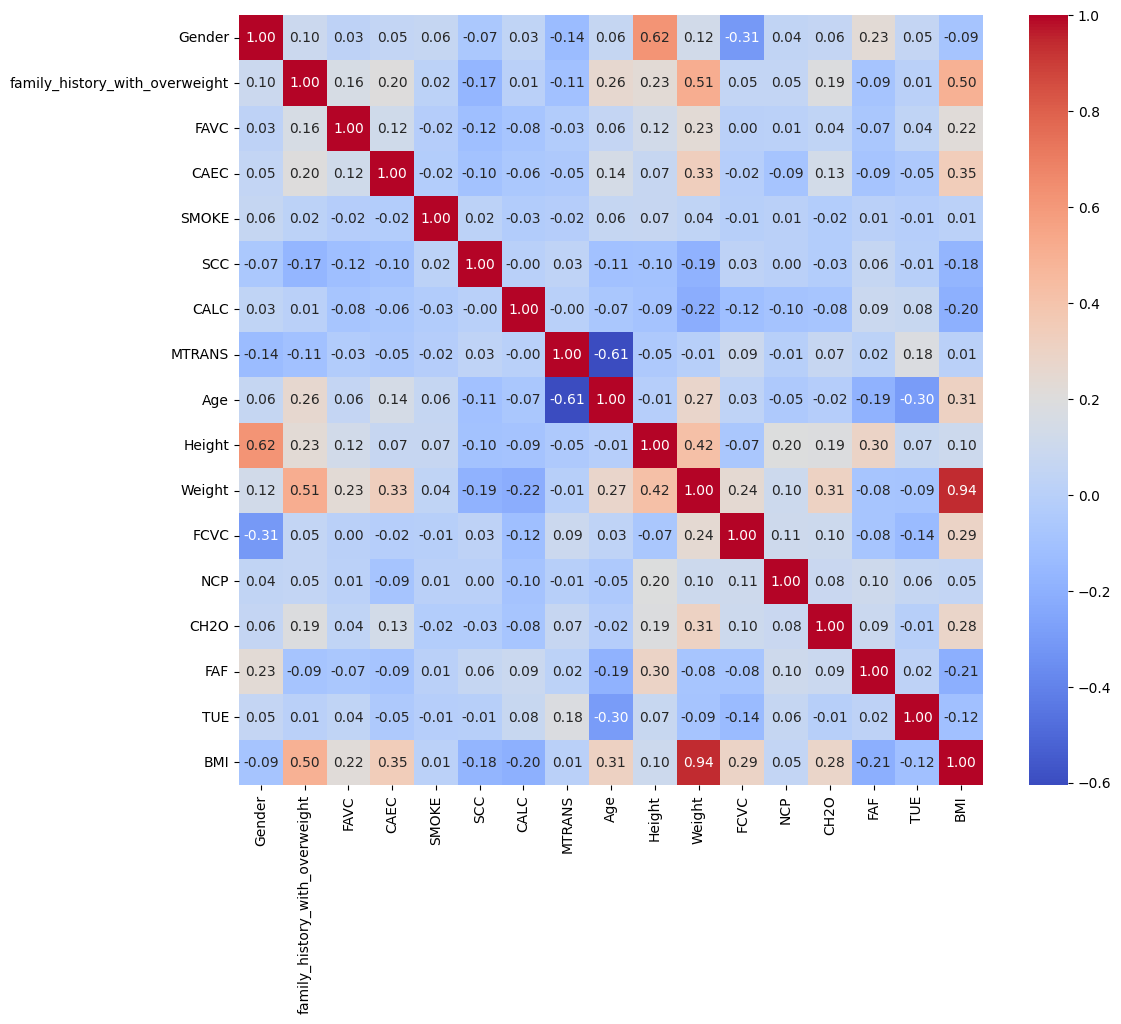

Height                            2.600075
Age                               0.926891
CH2O                              0.589738
FAF                               0.561610
TUE                               0.547585
FCVC                              0.454350
Gender                            0.289956
NCP                               0.273954
family_history_with_overweight    0.184918
CAEC                              0.169145
CALC                              0.125922
MTRANS                            0.105506
FAVC                              0.053450
SCC                               0.032672
SMOKE                             0.007235
dtype: float64


In [2]:
# correlation analysis to spot linear relationships
corr = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()  # helps us decide which features might be good predictors of bmi

# mutual information to catch non-linear relationships
X = data.drop(['BMI', 'Weight'], axis=1)  # focusing on features other than 'Weight'
y = data['BMI']
mi_scores = mutual_info_regression(X, y)
mi_results = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print(mi_results)  # higher scores mean more potential for predicting bmi

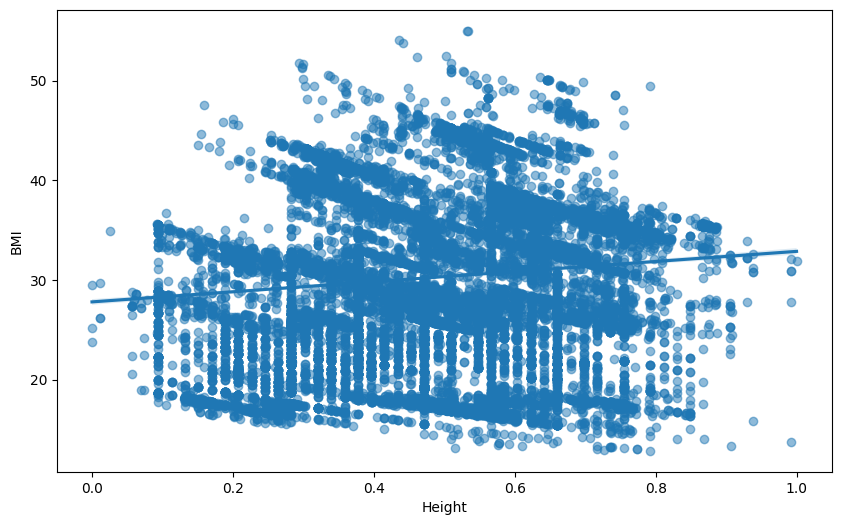

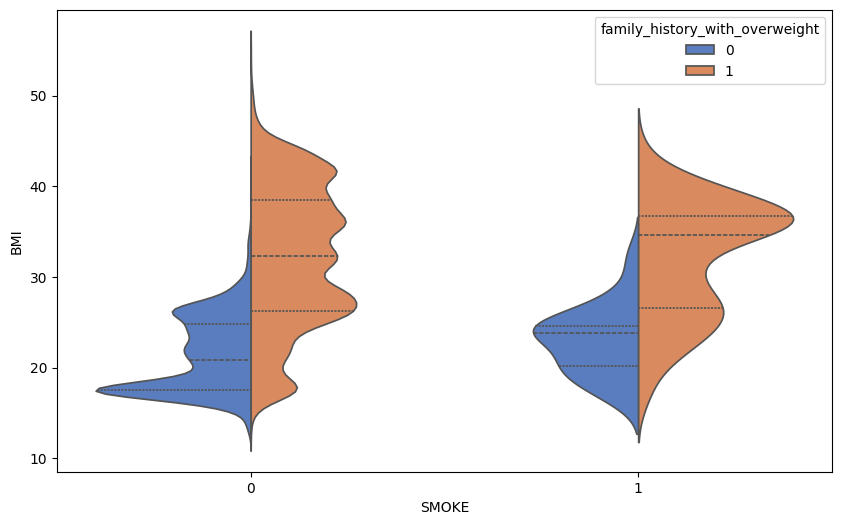

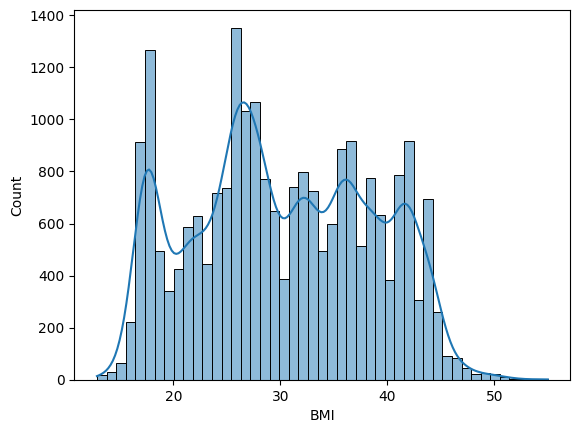

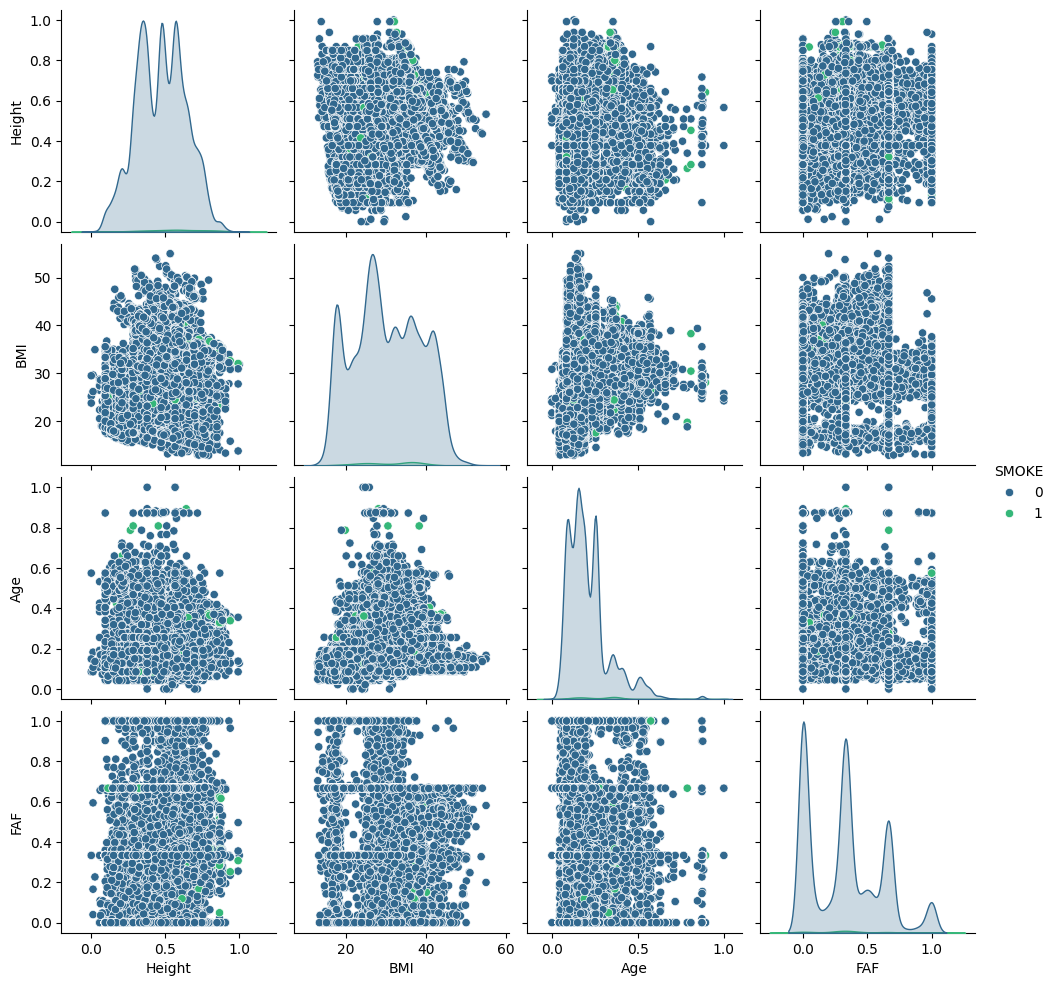

In [3]:
# visualizing the relationship between bmi and height, plus other insights
plt.figure(figsize=(10, 6))
sns.regplot(x='Height', y='BMI', data=data, scatter_kws={'alpha':0.5})
plt.show()  # confirms height's linear correlation with bmi

plt.figure(figsize=(10, 6))
sns.violinplot(x='SMOKE', y='BMI', hue='family_history_with_overweight', data=data, split=True, inner="quart", palette="muted")
plt.show()  # explores bmi distribution by smoking status and family history

sns.histplot(data['BMI'], kde=True)
plt.show()  # updates distplot to histplot for bmi distribution, considering deprecation

sns.pairplot(data, vars=['Height', 'BMI', 'Age', 'FAF'], hue='SMOKE', diag_kind='kde', kind='scatter', palette='viridis')
plt.show()  # deeper dive into feature interactions with bmi


In [7]:
# exploring bmi predictions with linear regression as our starting point
# the idea is to use a straightforward approach before diving into the complexities of neural networks
# we're including 'Height', 'Age', 'CH2O', and 'FAF' based on insights from our data analysis
# these features were chosen because they seemed to have a notable relationship with bmi, offering a mix of direct and subtle influences

# preparing the dataset with our chosen features for the model
X_expanded = data[['Height', 'Age', 'CH2O', 'FAF']]
y = data['BMI']  # bmi remains our target variable across models

# splitting the data into training and test sets to evaluate our model's performance
X_train_exp, X_test_exp, y_train, y_test = train_test_split(X_expanded, y, test_size=0.2, random_state=42)

# setting up and training the linear regression model on our selected features
lr_model = LinearRegression()
lr_model.fit(X_train_exp, y_train)

# now that our model's trained, we're using it to make bmi predictions on the test set
lr_predictions = lr_model.predict(X_test_exp)

# evaluating how well our linear regression model did
# we're looking at mean absolute error and mean squared error as our main metrics
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions)
print(f"Linear Regression MAE: {lr_mae:.2f}, MSE: {lr_mse:.2f}")

# pulling together the equation of our linear regression model for interpretability
# this will help us see directly how each feature is weighing in the bmi predictions
coefficients = lr_model.coef_
intercept = lr_model.intercept_
features = ['Height', 'Age', 'CH2O', 'FAF']
equation = "BMI = {:.4f}".format(intercept) + " " + " ".join(["+ ({:.4f} * {})".format(coef, feature) for coef, feature in zip(coefficients, features)])
print("Linear Regression Equation:", equation)


Linear Regression MAE: 5.96, MSE: 53.40
Linear Regression Equation: BMI = 21.6036 + (5.6763 * Height) + (19.0296 * Age) + (7.8221 * CH2O) + (-6.3560 * FAF)


In [6]:
# Starting with a simple neural network focusing on 'Height' and 'Age' based on mutual information and correlation analysis
# 'Height' and 'Age' were selected because they demonstrated strong linear and non-linear relationships with BMI, respectively
# This decision is based on the premise that a simpler model can provide a baseline understanding of how these key features predict BMI

# Preparing the data with the selected features for a more informed yet still focused model approach
enhanced_simple_features = data[['Height', 'Age', 'CH2O', 'FAF']]
enhanced_simple_target = data['BMI']

# Preprocessing: Scaling the selected features to ensure they're on the same scale for model input
enhanced_simple_preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), ['Height', 'Age', 'CH2O', 'FAF'])])
enhanced_simple_X_train, enhanced_simple_X_test, enhanced_simple_y_train, enhanced_simple_y_test = train_test_split(enhanced_simple_features, enhanced_simple_target, test_size=0.2, random_state=42)

# Define the enhanced simple neural network model architecture
# The model includes an input layer adapted for the four features, aiming to capture their combined effects on BMI
enhanced_simple_model = Sequential([
    Dense(64, activation='relu', input_shape=[4]),  # Adjusted input layer for four features
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for BMI prediction
])
enhanced_simple_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Train the enhanced simple model
enhanced_X_train_transformed = enhanced_simple_preprocessor.fit_transform(enhanced_simple_X_train)
enhanced_X_test_transformed = enhanced_simple_preprocessor.transform(enhanced_simple_X_test)
enhanced_simple_model.fit(enhanced_X_train_transformed, enhanced_simple_y_train, epochs=20, validation_split=0.2, verbose=1)

# Evaluate the enhanced simple model's performance
enhanced_simple_predictions = enhanced_simple_model.predict(enhanced_X_test_transformed).flatten()
enhanced_simple_mae = mean_absolute_error(enhanced_simple_y_test, enhanced_simple_predictions)
enhanced_simple_mse = mean_squared_error(enhanced_simple_y_test, enhanced_simple_predictions)
print(f"Enhanced Simple NN MAE: {enhanced_simple_mae:.2f}, MSE: {enhanced_simple_mse:.2f}")



Epoch 1/20
458/458 [==============================] - 1s 1ms/step - loss: 246.3181 - mae: 12.1144 - mse: 246.3181 - val_loss: 74.6062 - val_mae: 6.9688 - val_mse: 74.6062
Epoch 2/20
458/458 [==============================] - 1s 1ms/step - loss: 64.6406 - mae: 6.4844 - mse: 64.6406 - val_loss: 55.2657 - val_mae: 6.0227 - val_mse: 55.2657
Epoch 3/20
458/458 [==============================] - 0s 1ms/step - loss: 52.4849 - mae: 5.8538 - mse: 52.4849 - val_loss: 47.3374 - val_mae: 5.5741 - val_mse: 47.3374
Epoch 4/20
458/458 [==============================] - 0s 1ms/step - loss: 44.8386 - mae: 5.3520 - mse: 44.8386 - val_loss: 41.1368 - val_mae: 5.1763 - val_mse: 41.1368
Epoch 5/20
458/458 [==============================] - 1s 1ms/step - loss: 40.8212 - mae: 5.0356 - mse: 40.8212 - val_loss: 38.1019 - val_mae: 4.8523 - val_mse: 38.1019
Epoch 6/20
458/458 [==============================] - 1s 1ms/step - loss: 39.1289 - mae: 4.9128 - mse: 39.1289 - val_loss: 37.0289 - val_mae: 4.7638 - val_ms